In [1]:
import gymnasium as gym
import gym_donkeycar

import os
from ruamel.yaml import YAML
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

from PIL import Image
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

from networks.utils import to_np, load_config, save_image_and_reconstruction

# custom classes and functions
from networks.blocks import ConvBlock, CategoricalStraightThrough
from networks.rssm import RSSM
from networks.mlp import MLP
from networks.categorical_vae import CategoricalVAE
from networks.actor_critic import ContinuousActorCritic
from preprocessing import grayscale_transform as transform

torch.cuda.empty_cache()
%matplotlib inline

/home/till/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
device = torch.device("cpu")

## Init the environment

## Playground  \~( ˘▾˘~)

## AC training loop for Cartpole

In [3]:
# environment hyperparams
n_envs = 1
n_updates = 30000
n_steps_per_update = 128

agent = ContinuousActorCritic(
     n_features=3, 
     n_actions=1,
     n_envs=n_envs,
     gamma=0.999,
     lam=0.95,
     entropy_coeff=0.01,
     critic_lr=5e-4, # it's very sensitive to higher learning rates (gets nans)
     actor_lr=1e-4,
    action_clip=2
).to(device)

In [4]:
# create a wrapper environment to save episode returns and episode lengths
envs = gym.vector.make("Pendulum-v1", num_envs=n_envs, max_episode_steps=200)
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs*n_updates)

# Logging
log_dir = "logs/"
writer = SummaryWriter(log_dir)
notebook.start(f"--logdir={log_dir}")

critic_losses = []
actor_losses = []
entropies = []

for sample_phase in tqdm(range(n_updates)):
    
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_entropies = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    if sample_phase == 0:
        obs, info = envs_wrapper.reset(seed=0)
        obs = torch.Tensor(obs)

    for step in range(n_steps_per_update):
        
        # get action and value
        action, log_prob, actor_entropy = agent.get_action(obs)
        value_pred = agent.critic(obs)

        # env step
        obs, reward, terminated, truncated, infos = envs_wrapper.step(to_np(action))
        obs = torch.Tensor(obs)

        ep_value_preds[step] = value_pred.squeeze()
        ep_rewards[step] = torch.tensor(reward, device=device)
        ep_log_probs[step] = log_prob.squeeze()
        ep_entropies[step] = actor_entropy.squeeze()

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        # dones = np.logical_or(terminated, truncated)
        ep_masks[step] = torch.Tensor([not term for term in terminated], device=device) # terminated/dones

    # calculate the losses for actor and critic
    last_value_pred = agent.critic(obs)
    critic_loss, actor_loss = agent.get_loss(ep_rewards, ep_log_probs, ep_value_preds, last_value_pred,
                                             ep_entropies, ep_masks)

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    if envs_wrapper.return_queue:
        writer.add_scalar("episode_return", envs_wrapper.return_queue[-1], global_step=sample_phase)
    writer.add_scalar("actor_loss", to_np(actor_loss), global_step=sample_phase)
    writer.add_scalar("critic_loss", to_np(critic_loss), global_step=sample_phase)
    writer.add_scalar("actor_entropy", to_np(ep_entropies.mean()), global_step=sample_phase)
    critic_losses.append(to_np(critic_loss))
    actor_losses.append(to_np(actor_loss))
    entropies.append(to_np(ep_entropies.mean()))

  0%|                                                                                                 | 0/30000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 54%|████████████████████████████████████████████▌                                      | 16098/30000 [1:04:38<55:49,  4.15it/s]


KeyboardInterrupt: 

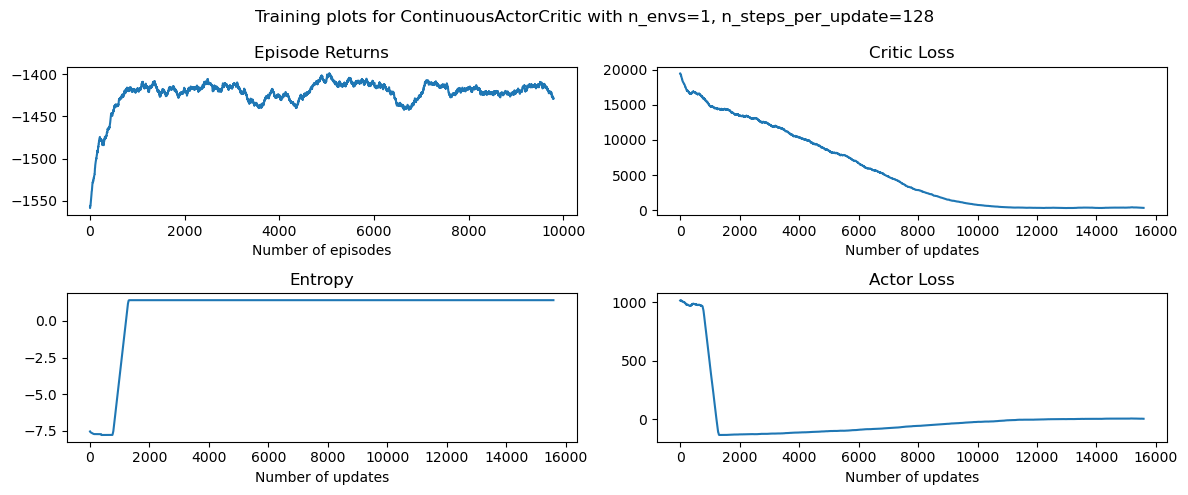

In [5]:
""" Plot the results """

rolling_length = max(1, int(len(envs_wrapper.return_queue) / 20))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")

# Episode return
axs[0, 0].set_title("Episode Returns")
episode_returns_moving_average = np.convolve(np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
axs[0, 0].set_xlabel("Number of episodes")

# Entropy
axs[1, 0].set_title("Entropy")
entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 0].plot(entropy_moving_average)
axs[1, 0].set_xlabel("Number of updates")

# Critic loss
axs[0, 1].set_title("Critic Loss")
critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 1].plot(critic_losses_moving_average)
axs[0, 1].set_xlabel("Number of updates")

# Actor loss
axs[1, 1].set_title("Actor Loss")
actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 1].plot(actor_losses_moving_average)
axs[1, 1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [7]:
np.std(episode_returns)

181.67203

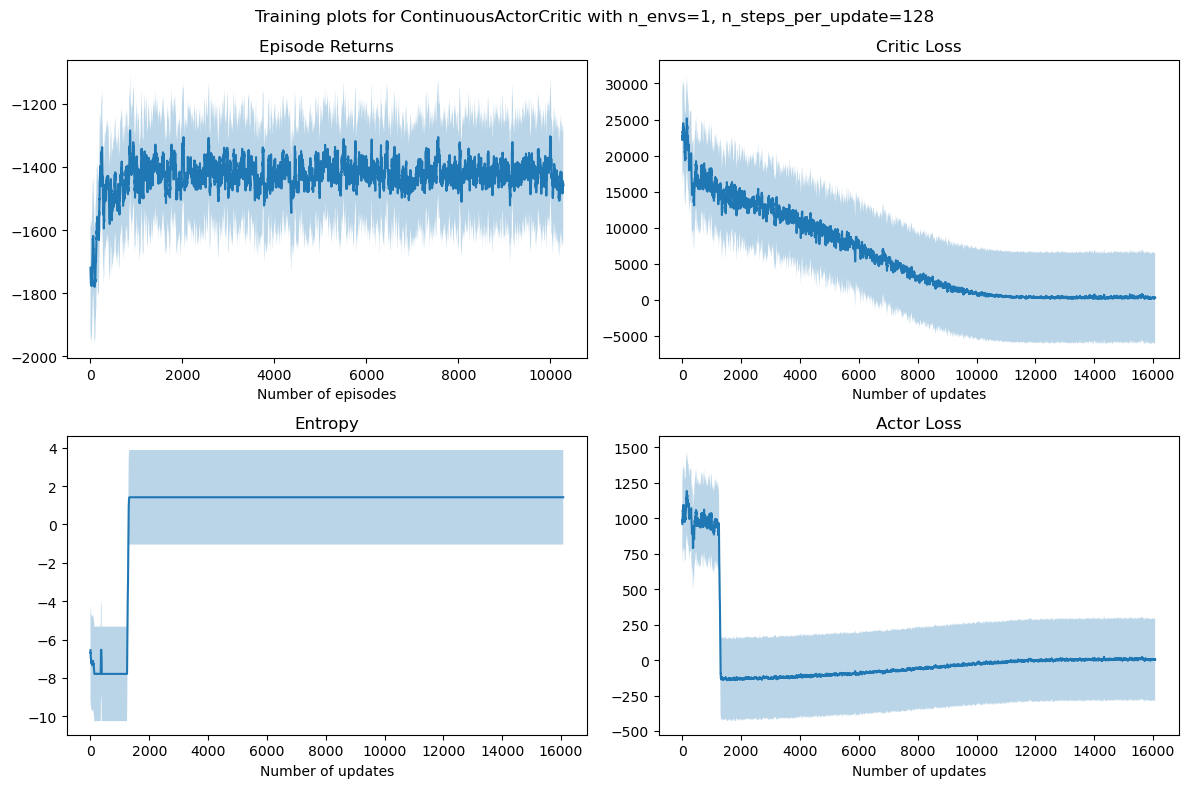

In [17]:
rolling_length = max(1, int(len(envs_wrapper.return_queue) / 400))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")

# Episode return
axs[0, 0].set_title("Episode Returns")
episode_returns = np.array(envs_wrapper.return_queue).flatten()
episode_returns_moving_average = np.convolve(episode_returns, np.ones(rolling_length), mode="valid") / rolling_length
episode_returns_std = np.std(episode_returns)
axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
axs[0, 0].fill_between(np.arange(len(episode_returns_moving_average)) / n_envs,
                       episode_returns_moving_average - episode_returns_std,
                       episode_returns_moving_average + episode_returns_std,
                       alpha=0.3)
axs[0, 0].set_xlabel("Number of episodes")

# Entropy
axs[1, 0].set_title("Entropy")
entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
entropy_std = np.std(entropies)
axs[1, 0].plot(entropy_moving_average)
axs[1, 0].fill_between(np.arange(len(entropy_moving_average)),
                       entropy_moving_average - entropy_std,
                       entropy_moving_average + entropy_std,
                       alpha=0.3)
axs[1, 0].set_xlabel("Number of updates")

# Critic loss
axs[0, 1].set_title("Critic Loss")
critic_losses = np.array(critic_losses).flatten()
critic_losses_moving_average = np.convolve(critic_losses, np.ones(rolling_length), mode="valid") / rolling_length
critic_losses_std = np.std(critic_losses)
axs[0, 1].plot(critic_losses_moving_average)
axs[0, 1].fill_between(np.arange(len(critic_losses_moving_average)),
                       critic_losses_moving_average - critic_losses_std,
                       critic_losses_moving_average + critic_losses_std,
                       alpha=0.3)
axs[0, 1].set_xlabel("Number of updates")

# Actor loss
axs[1, 1].set_title("Actor Loss")
actor_losses = np.array(actor_losses).flatten()
actor_losses_moving_average = np.convolve(actor_losses, np.ones(rolling_length), mode="valid") / rolling_length
actor_losses_std = np.std(actor_losses)
axs[1, 1].plot(actor_losses_moving_average)
axs[1, 1].fill_between(np.arange(len(actor_losses_moving_average)),
                       actor_losses_moving_average - actor_losses_std,
                       actor_losses_moving_average + actor_losses_std,
                       alpha=0.3)
axs[1, 1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()


## Showcase

In [12]:
envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")

obs, info = envs.reset(seed=0)
obs = torch.Tensor(obs)

for step in range(n_steps_per_update):
    
    # get action and value
    action, action_log_probs, actor_entropy = agent.get_action(obs)
    
    # env step
    obs, rewards, terminated, truncated, infos = envs.step(to_np(action))
    obs = torch.Tensor(obs)

envs.close()

/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
# envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")
# 
# obs, info = envs.reset(seed=0)
# obs = torch.Tensor(obs)
# 
# for step in range(n_steps_per_update):
#     
#     # get action and value
#     action, state_value, action_log_probs, actor_entropy = agent.select_action(obs)
#     continuous_action = []
#     for idx in actions:
#         continuous_action.append([idx_to_action[idx.item()]])
#     #print(continuous_action)
#     # env step
#     obs, rewards, terminated, truncated, infos = envs.step(continuous_action)
#     obs = torch.Tensor(obs)
# 
# envs.close()

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective

In [ ]:
space  = [
    Real(0, 1, name="gamma"),
    Real(0, 1, name="lam"),
    Real(10**-10, 10**4, "log-uniform", name="ent_coef"),
    Real(10**-5, 10**0, "log-uniform", name="actor_lr"),
    Real(10**-5, 10**0, "log-uniform", name="critic_lr"),
]

In [ ]:
# # environment hyperparams
# n_envs = 1
# n_updates = 1000
# n_steps_per_update = 128
# 
# # agent hyperparams
# gamma = 0.999
# lam = 0.95  # hyperparameter for GAE
# ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
# actor_lr = 0.001
# critic_lr = 0.005
# 
# agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs)

In [ ]:
@use_named_args(space)
def objective(**params):
    """  The objective we want to MINIMIZE """
    
    # for a neural net
    # model.set_params(**params)
    # return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))
    
    print(params)
    # result = 0
    # for x in params.values():
    #     result -= x
    # return result
    
    # environment hyperparams
    n_envs = 1
    n_updates = 1000
    n_steps_per_update = 128

    # agent hyperparams
    gamma = params["gamma"]
    lam = params["lam"]
    ent_coef = params["ent_coef"]
    actor_lr = params["actor_lr"]
    critic_lr = params["critic_lr"]

    agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs, gamma, lam, ent_coef)

    return_queue, critic_losses, actor_losses, entropies = train(
        n_envs, n_updates, n_steps_per_update) # we want to maximize this
    
    result = - sum(return_queue) # we want to minimize this
    # print("result:", result, "(we want to minimize this)")
    return result

In [ ]:
from skopt import gp_minimize
gp_result = gp_minimize(
    objective, 
    space, 
    n_calls=20, 
    random_state=0)

print("Best score:", gp_result.fun)

In [ ]:
plot_convergence(gp_result)

In [ ]:
plot_objective(gp_result)

In [ ]:
""" train an agent with the best params """

print("best parameters:", gp_result.x)

gamma, lam, ent_coef, actor_lr, critic_lr = gp_result.x
agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs, gamma, lam, ent_coef)

# set longer training time
n_envs = 1
n_updates = 3000
n_steps_per_update = 128

return_queue, critic_losses, actor_losses, entropies = train(n_envs, n_updates, n_steps_per_update)

In [ ]:
""" Plot the results """

rolling_length = max(1, int(len(return_queue) / 20))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")

# Episode return
axs[0, 0].set_title("Episode Returns")
episode_returns_moving_average = np.convolve(np.array(return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
axs[0, 0].set_xlabel("Number of episodes")

# Entropy
axs[1, 0].set_title("Entropy")
entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 0].plot(entropy_moving_average)
axs[1, 0].set_xlabel("Number of updates")

# Critic loss
axs[0, 1].set_title("Critic Loss")
critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 1].plot(critic_losses_moving_average)
axs[0, 1].set_xlabel("Number of updates")

# Actor loss
axs[1, 1].set_title("Actor Loss")
actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 1].plot(actor_losses_moving_average)
axs[1, 1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [ ]:
envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")

obs, info = envs.reset(seed=0)
obs = torch.Tensor(obs)

for step in range(n_steps_per_update):
    
    # get action and value
    action, state_value, action_log_probs, actor_entropy = agent.select_action(obs)
    continuous_action = []
    for idx in actions:
        continuous_action.append([idx_to_action[idx.item()]])
    #print(continuous_action)
    # env step
    obs, rewards, terminated, truncated, infos = envs.step(continuous_action)
    obs = torch.Tensor(obs)

envs.close()